Dados utilizados:


1.   `Diário`: https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_AGGR
2.   `Mensal`: https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY_AGGR



#**Instalações iniciais**

In [1]:
# Instalando matplotlib, proplot e numpy
!pip install -q matplotlib==3.4.3
!pip install -q proplot==0.9.7
!pip install -q numpy==1.24.3

# Instalando salem
!pip install -q salem==0.3.9

# Instalando cartopy
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy

# instalando eemont e wxee
!pip install -q eemont wxee

Found existing installation: shapely 2.0.3
Uninstalling shapely-2.0.3:
  Successfully uninstalled shapely-2.0.3


- Chegando aqui, será necessário fazer a `Reinicialização do Ambiente de Execução`. Para isto, você deverá acessar `Ambiente de execução`, localizado na barra de ferramentas e clicar em `Reiniciar Sessão`. Como indicado na imagem abaixo.

- Em seguida você deverá rodar novamente a célula anterior de instalações, de forma que as bibliotecas sejam instaladas novamente.

- Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab. Então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual da disciplina.

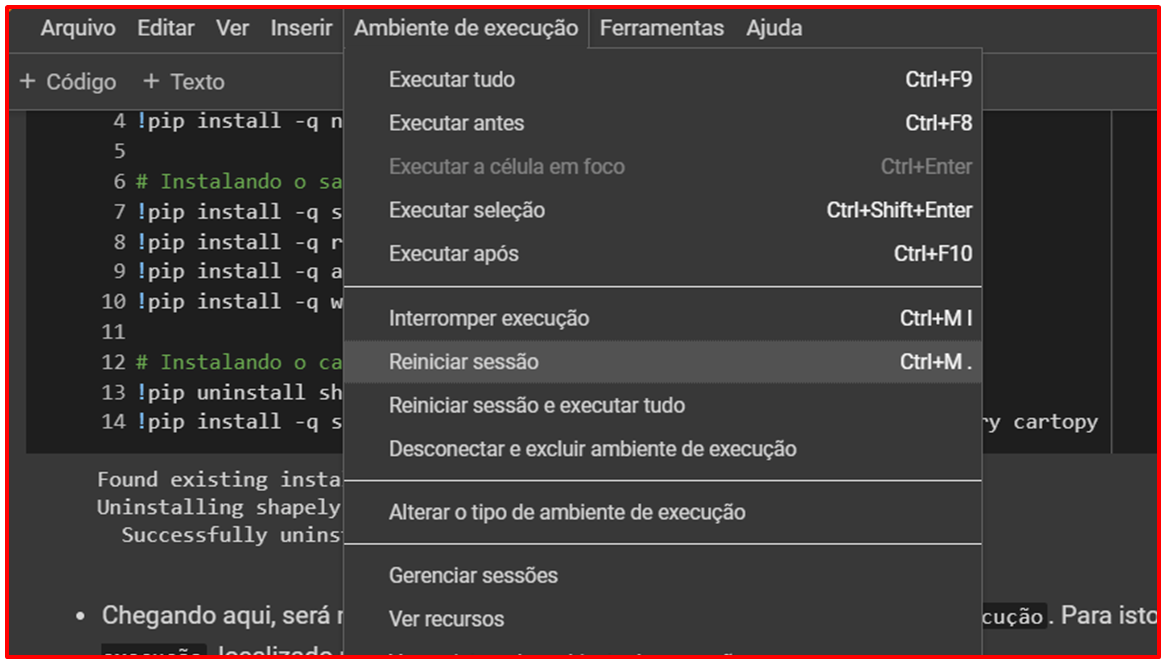

In [3]:
# importando GEE e geemap
import ee, geemap, eemont, wxee

# inicializando GEE
geemap.ee_initialize()

# importando demais bibliotecas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import proplot as pplt
import salem
from datetime import datetime
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# monta o drive
from google.colab import drive
drive.mount('/content/drive')

# define o caminho
dir = '/content/drive/MyDrive/PYHTON/00_GITHUB/ATUAL_GEE/03_AULAS/AULA_11_ERA5/'

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=pDiapDXAmeydz-d5mUz6u2iB0PV1L-xyC3Qa27-591I&tc=RecPSZbN7eMWNUfRlYuYosAqL3GlRioaxQRPcsXJRkU&cc=vzqBkyNVJKTzYaBFWGytdXmf3PeXsSqetKAqVtRFUbc

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AeaYSHB2GsjRGLNhEDSX5zoXLVXRYlvR87FJcpNY9r60jO01qsGfUCd81A4

Successfully saved authorization token.


/usr/local/lib/python3.10/dist-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


Mounted at /content/drive


# **PARTE 1)**:  Conhecendo os dados - Mapa simples

In [16]:
# carregando os dados
t2m = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .select('temperature_2m') \
        .filterDate('2023-01-01', '2023-02-01')

# mostra as informações da primeira imagem
t2m.first()

In [14]:
# filtrar região de interesse
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
estado_sp = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
municipio_sp = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo'))

# função que transforma de Kelvin para Celsius
def kelvin_to_celsius(image):
    return image.subtract(273.15)\
                .copyProperties(image, ['system:time_start'])\
                .set('date', image.date().format('YYYY-MM-dd'))

# carregando os dados
t2m = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .select('temperature_2m') \
        .filterDate('2023-12-01', '2024-01-01') \
        .map(kelvin_to_celsius) \
        .max()

# paleta de cores
vis_t2m = {'min': 10,
           'max': 40,
           'palette': ['000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff', '00ff80',
                       '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00', 'ffb000', 'ffa400',
                       'ff4f00', 'ff2500', 'ff0a00', 'ff00ff']}

# cria a moldura do mapa
Map = geemap.Map()

# centraliza o mapa
Map.centerObject(estado_sp)

# plota mapa
Map.addLayer(t2m.clip(estado_sp),
             vis_t2m,
             'Temperatura máxima em 2m')

# contorno da região
style1 = {'color': 'black', 'fillColor': '00000000'}
style2 = {'color': 'red', 'fillColor': '00000000'}
Map.addLayer(estado_sp.style(**style1), {}, 'estado_SP')
Map.addLayer(municipio_sp.style(**style2), {}, 'cidade_SP')

# barra de cores
colors = vis_t2m["palette"]
vmin = vis_t2m["min"]
vmax = vis_t2m["max"]
Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name='Temperatura')

# exibe na tela
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# **PARTE 2)**:  Série temporal

##Gera tabela

In [15]:
%%time
#========================================================================================================================#
#                                        Filtrar região de interesse
#========================================================================================================================#
municipio_sp = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo'))

#========================================================================================================================#
#                                Função que transforma de Kelvin para Celsius
#========================================================================================================================#
def kelvin_to_celsius(image):
    return image.subtract(273.15)\
                .copyProperties(image, ['system:time_start'])\
                .set('date', image.date().format('YYYY-MM-dd'))

#========================================================================================================================#
#                                            Loop nos anos
#========================================================================================================================#
# intervalo da série temporal: 1950-2024
time1 = [1950, 1960, 1970, 1980, 1990, 2000, 2010]
time2 = [1960, 1970, 1980, 1990, 2000, 2010, 2025]

# loop dos tempos
for t1, t2 in zip(time1, time2):

    print('....PROCESSANDO----->>', f'{str(t1)}-{str(t2)}')

    #-------------------------------#
    #      carrega os dados
    #-------------------------------#
    t2m = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
            .select('temperature_2m') \
            .filterDate(str(t1), str(t2)) \
            .map(kelvin_to_celsius)

    #-------------------------------#
    #        série temporal
    #-------------------------------#
    # gera a serie temporal
    t2m_ts = t2m.getTimeSeriesByRegion(geometry = municipio_sp,
                                       bands = 'temperature_2m',
                                       reducer = ee.Reducer.max(),
                                       scale = 11_000)

    # inserindo os dados numa tabela
    t2m_ts = geemap.ee_to_df(t2m_ts)

    # transformando -9999.0 em NaN
    t2m_ts[t2m_ts == -9999] = np.nan

    # eliminando os dados NaN
    t2m_ts = t2m_ts.dropna()

    # transformando para DateTime
    t2m_ts['date'] = pd.to_datetime(t2m_ts['date'], infer_datetime_format = True)

    # transformando a coluna de datas('date') no índice do DataFrame
    t2m_ts.index = t2m_ts['date']

    #-------------------------------#
    #   Salva num arquivo CSV
    #-------------------------------#
    t2m_ts.to_csv(f'{dir}output/t2m_diaria_{str(t1)}_{str(t2)}.csv')

#========================================================================================================================#
#                                         Junta os DataFrames
#========================================================================================================================#
# junta os dataframes
df = pd.DataFrame()
for file in sorted(glob.glob(f'{dir}output/t2m_diaria*')):

    # leitura da tabela
    df0 = pd.read_csv(file, delimiter=',')

    # junta a tabela que foi lida com a anterior
    df = pd.concat([df, df0], ignore_index=True)

# remove colunas
df.drop(['reducer', 'date.1'], inplace=True, axis=1)

# salva tabela final
df.to_csv(f'{dir}output/ERA5_t2m_diaria_{str(time1[0])}_{str(time2[-1]-1)}.csv')

# remove tabelas: t2m_diaria_1950_1960.csv
for file in glob.glob(f'{dir}output/t2m_diaria*'):
    os.remove(file)

# exibe tabela final
df

....PROCESSANDO----->> 1950-1960
....PROCESSANDO----->> 1960-1970
....PROCESSANDO----->> 1970-1980
....PROCESSANDO----->> 1980-1990
....PROCESSANDO----->> 1990-2000
....PROCESSANDO----->> 2000-2010
....PROCESSANDO----->> 2010-2025
CPU times: user 3.02 s, sys: 346 ms, total: 3.36 s
Wall time: 6min 47s


date  temperature_2m
0      1950-01-02       21.021004
1      1950-01-03       19.309481
2      1950-01-04       21.434169
3      1950-01-05       22.537501
4      1950-01-06       19.579994
...           ...             ...
27045  2024-01-19       25.091018
27046  2024-01-20       24.841100
27047  2024-01-21       22.209275
27048  2024-01-22       20.908067
27049  2024-01-31       23.388796

[27050 rows x 2 columns]

##Plota figura - Série temporal de temperatura `diária`

CPU times: user 1min 6s, sys: 1.54 s, total: 1min 7s
Wall time: 1min 9s


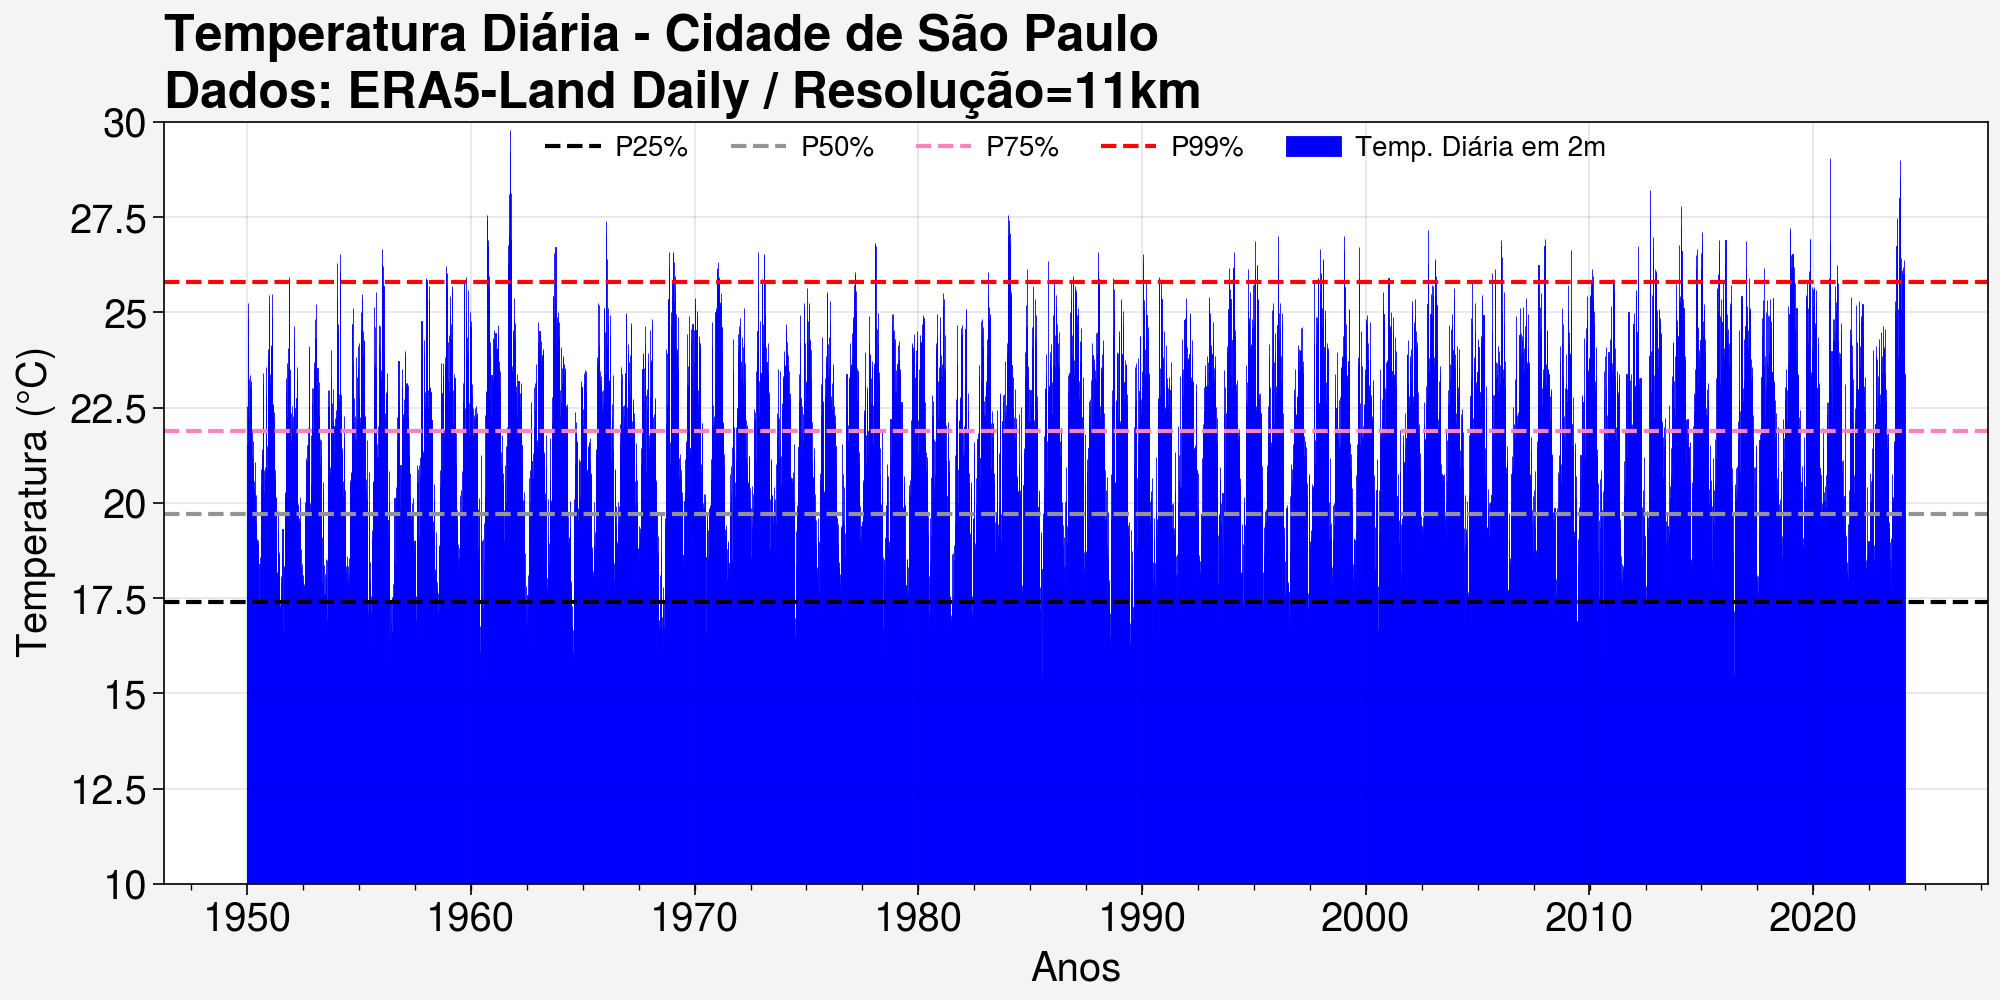

In [17]:
%%time
#========================================================================================================================#
#                                              LEITURA DO DADO
#========================================================================================================================#
# leitura do arquivo
df = pd.read_csv(f'{dir}output/ERA5_t2m_diaria_1950_2024.csv')

# transformando para DateTime
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)

# transformando a coluna de datas('date') no índice do DataFrame
df.index = df['date']

# remove colunas
df.drop(['Unnamed: 0', 'date'], inplace=True, axis=1)

#========================================================================================================================#
#                                                PLOTA FIGURA
#========================================================================================================================#
# moldura da figura
fig, ax = pplt.subplots(figsize=(10,5), tight=True)

# plota gráfico de barras
ax.bar(df['temperature_2m'].index, df['temperature_2m'], color='blue', label='Temp. Diária em 2m')

# plota percentil de 25%, 50%, 75% e 99%
ax.axhline(np.percentile(df['temperature_2m'].values, 25), color='black', linestyle='--', label='P25%')
ax.axhline(np.percentile(df['temperature_2m'].values, 50), color='gray', linestyle='--', label='P50%')
ax.axhline(np.percentile(df['temperature_2m'].values, 75), color='pink', linestyle='--', label='P75%')
ax.axhline(np.percentile(df['temperature_2m'].values, 99), color='bright red', linestyle='--', label='P99%')

# formato dos eixos
# https://proplot.readthedocs.io/en/stable/subplots.html
# https://proplot.readthedocs.io/en/latest/api/proplot.axes.Axes.format.html
ax.format(title=f'Temperatura Diária - Cidade de São Paulo \nDados: ERA5-Land Daily / Resolução=11km',
          titleloc='l',
          titleweight='bold',
          titlecolor='black',
          xlabel='Anos',
          ylabel='Temperatura ($\degree$C)',
          ytickminor=False,
          small='20px',
          large='25px',
          xrotation=0,
          ylim=(10,30))

# legenda
ax.legend(loc='best', ncols=5, frameon=False, prop={'size':10})

# salva figura
fig.save(f'{dir}output/Fig_1_ERA5_t2m_serie_temporal_diaria.jpg', dpi=300)

##Plota figura - Série temporal de temperatura `anual`

In [18]:
df

temperature_2m
date                      
1950-01-02       21.021004
1950-01-03       19.309481
1950-01-04       21.434169
1950-01-05       22.537501
1950-01-06       19.579994
...                    ...
2024-01-19       25.091018
2024-01-20       24.841100
2024-01-21       22.209275
2024-01-22       20.908067
2024-01-31       23.388796

[27050 rows x 1 columns]

In [19]:
df.groupby(pd.Grouper(freq='1Y')).mean()

temperature_2m
date                      
1950-12-31       18.944337
1951-12-31       18.810989
1952-12-31       18.895770
1953-12-31       19.236282
1954-12-31       19.630597
...                    ...
2020-12-31       19.947934
2021-12-31       19.517994
2022-12-31       19.315281
2023-12-31       20.422853
2024-12-31       23.667789

[75 rows x 1 columns]

In [20]:
df.groupby(pd.Grouper(freq='1Y')).max()

temperature_2m
date                      
1950-12-31       25.457231
1951-12-31       25.934976
1952-12-31       24.645227
1953-12-31       25.208898
1954-12-31       26.522707
...                    ...
2020-12-31       29.051583
2021-12-31       26.247133
2022-12-31       25.295572
2023-12-31       28.993010
2024-12-31       26.366582

[75 rows x 1 columns]

In [21]:
anual_mean = df.groupby(pd.Grouper(freq='1Y')).mean()
anual_mean['temperature_2m'].index.year

Int64Index([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
            1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
            1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
            1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
            1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
            2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
            2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
           dtype='int64', name='date')

CPU times: user 651 ms, sys: 262 ms, total: 914 ms
Wall time: 700 ms


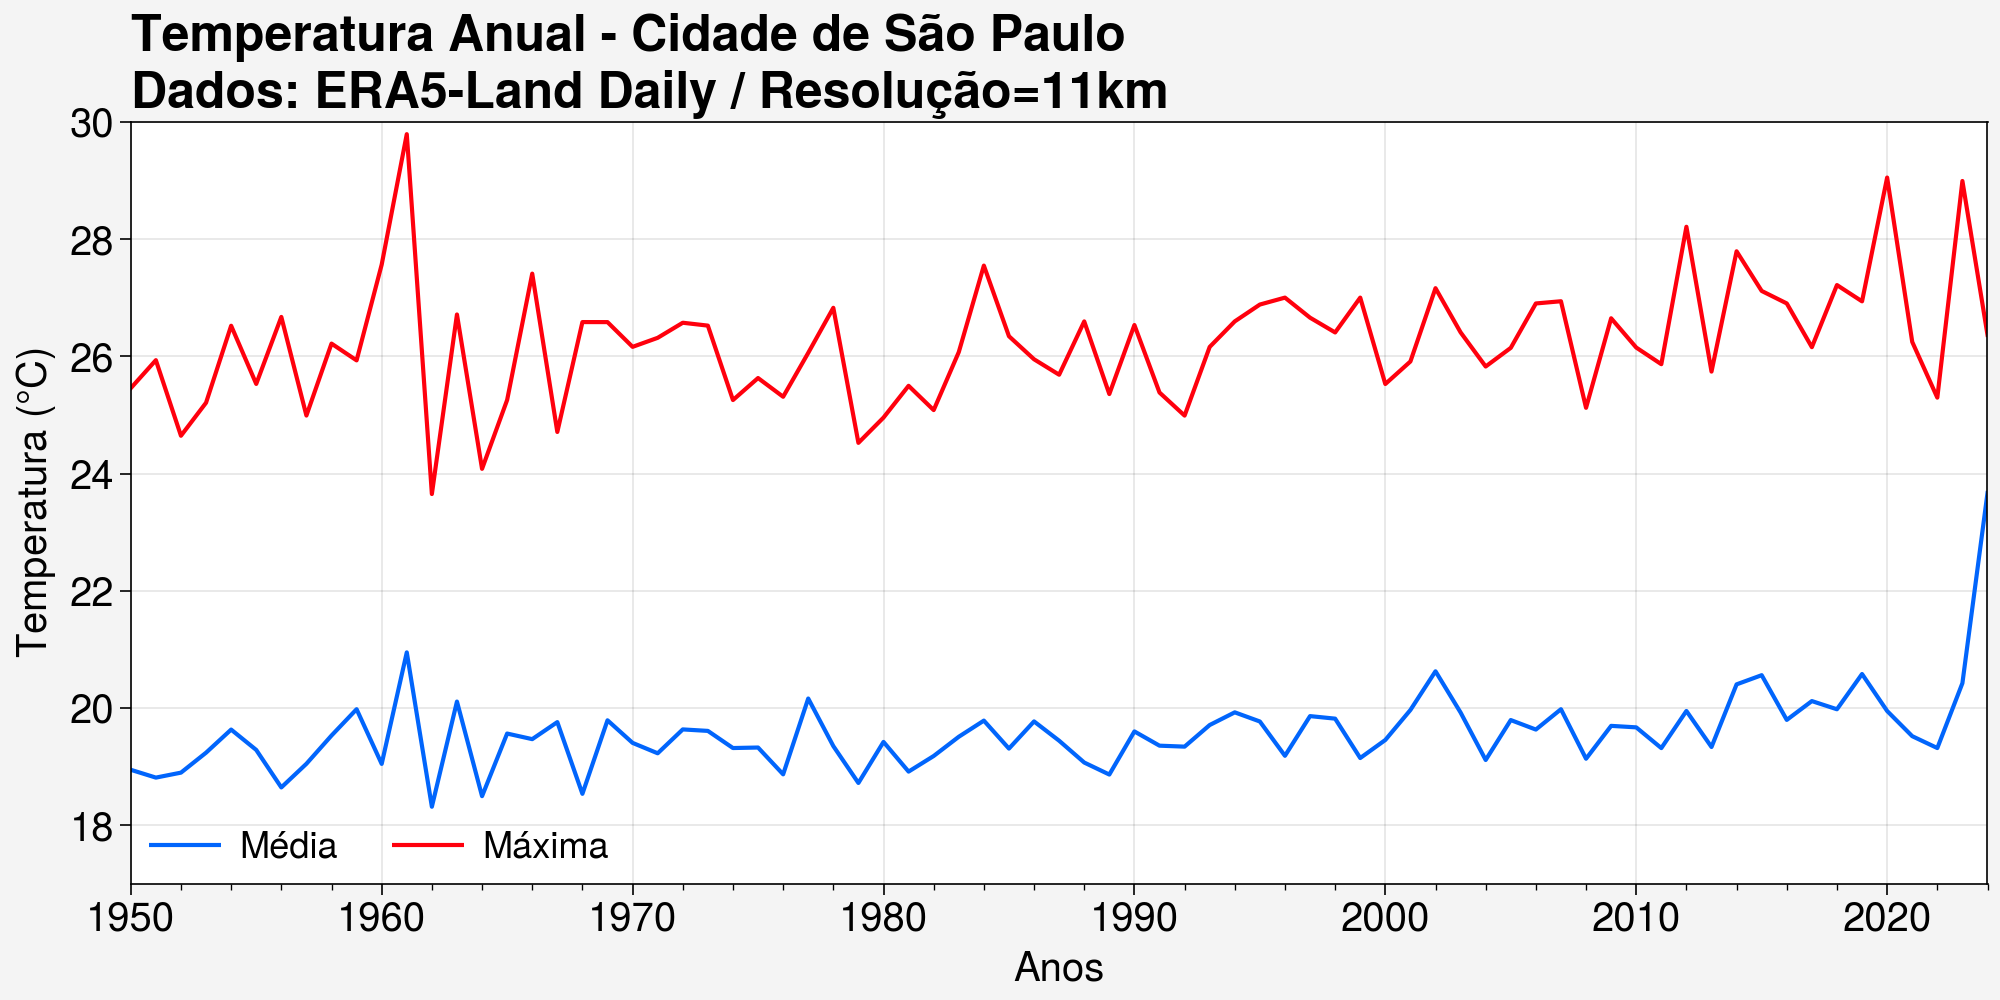

In [22]:
%%time
#========================================================================================================================#
#                                              LEITURA DO DADO
#========================================================================================================================#
# leitura do arquivo
df = pd.read_csv(f'{dir}output/ERA5_t2m_diaria_1950_2024.csv')

# transformando para DateTime
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)

# transformando a coluna de datas('date') no índice do DataFrame
df.index = df['date']

# remove colunas
df.drop(['Unnamed: 0', 'date'], inplace=True, axis=1)

#========================================================================================================================#
#                                          ACUMULA PARA ANUAL
#========================================================================================================================#
anual_mean = df.groupby(pd.Grouper(freq='1Y')).mean()
anual_max = df.groupby(pd.Grouper(freq='1Y')).max()

#========================================================================================================================#
#                                                PLOTA FIGURA
#========================================================================================================================#
# moldura da figura
fig, ax = pplt.subplots(figsize=(10,5), tight=True)

# plota gráfico de barras
ax.plot(anual_mean['temperature_2m'].index.year, anual_mean['temperature_2m'], color='bright blue', label='Média')
ax.plot(anual_max['temperature_2m'].index.year, anual_max['temperature_2m'], color='bright red', label='Máxima')

# formato dos eixos
ax.format(title=f'Temperatura Anual - Cidade de São Paulo \nDados: ERA5-Land Daily / Resolução=11km',
          titleloc='l',
          titleweight='bold',
          titlecolor='black',
          xlabel='Anos',
          ylabel='Temperatura ($\degree$C)',
          ytickminor=False,
          small='20px',
          large='25px',
          xrotation=0,
          ylim=(17,30))

# legenda
ax.legend(loc='best', ncols=2, frameon=False, prop={'size':13})

# salva figura
fig.save(f'{dir}output/Fig_2_ERA5_t2m_serie_temporal_anual.jpg', dpi=300)

## Plota figura - Série temporal de temperatura `mensal` por ano

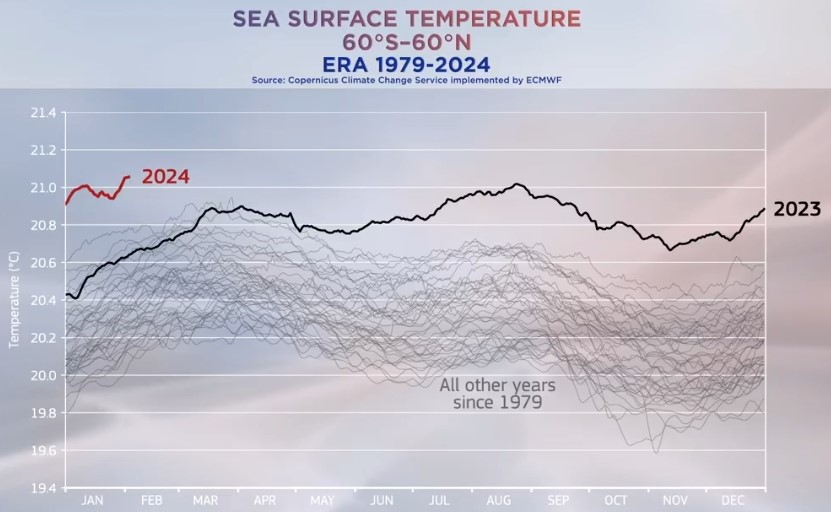

In [23]:
df

temperature_2m
date                      
1950-01-02       21.021004
1950-01-03       19.309481
1950-01-04       21.434169
1950-01-05       22.537501
1950-01-06       19.579994
...                    ...
2024-01-19       25.091018
2024-01-20       24.841100
2024-01-21       22.209275
2024-01-22       20.908067
2024-01-31       23.388796

[27050 rows x 1 columns]

In [24]:
df.groupby(pd.Grouper(freq='1M')).mean()

temperature_2m
date                      
1950-01-31       21.280014
1950-02-28       21.732116
1950-03-31       20.173756
1950-04-30       19.148747
1950-05-31       18.615633
...                    ...
2023-09-30       21.796834
2023-10-31       21.232560
2023-11-30       22.913851
2023-12-31       23.397334
2024-01-31       23.667789

[889 rows x 1 columns]

CPU times: user 769 ms, sys: 242 ms, total: 1.01 s
Wall time: 786 ms


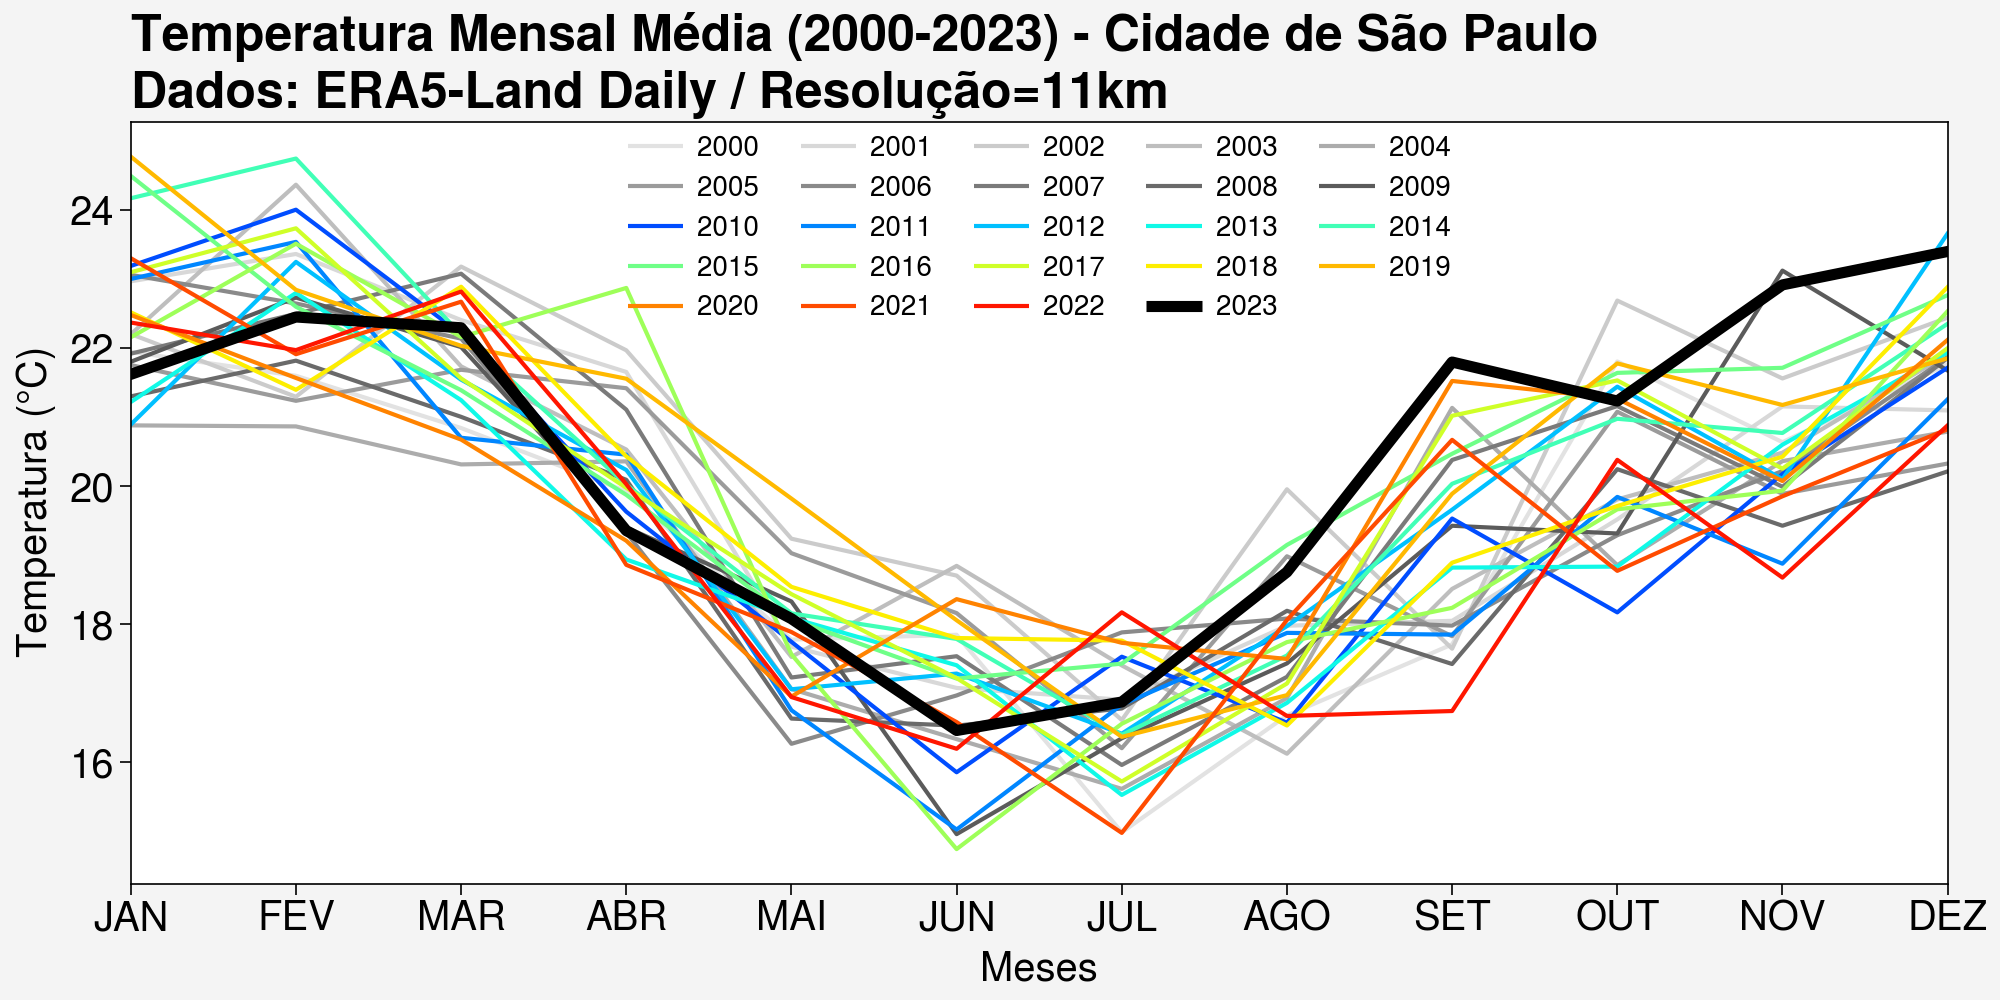

In [28]:
%%time
#========================================================================================================================#
#                                              LEITURA DO DADO
#========================================================================================================================#
# leitura do arquivo
df = pd.read_csv(f'{dir}output/ERA5_t2m_diaria_1950_2024.csv')

# transformando para DateTime
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)

# transformando a coluna de datas('date') no índice do DataFrame
df.index = df['date']

# remove colunas
df.drop(['Unnamed: 0', 'date'], inplace=True, axis=1)

#========================================================================================================================#
#                                          ACUMULA PARA MENSAL
#========================================================================================================================#
# valores por mês
df_mensal = df.groupby(pd.Grouper(freq='1M')).mean()

#========================================================================================================================#
#                                                PLOTA FIGURA
#========================================================================================================================#
# moldura da figura
fig, ax = pplt.subplots(figsize=(10,5), tight=True)

# plota gráfico de barras
# https://proplot.readthedocs.io/en/stable/basics.html

# 2000-2009
anoi, anof = 2000, 2009
cycle = pplt.Cycle('Greys', left=0.2, N=15)
for ano in np.arange(anoi, anof+1):
    dfx = df_mensal[str(ano)]
    ax.plot(pplt.arange(1, 12, 1), df_mensal[str(ano)]['temperature_2m'], label=str(ano), cycle=cycle)

# 2010-2022
anoi, anof = 2010, 2022
cycle = pplt.Cycle('jet', left=0.2, N=15)
for ano in np.arange(anoi, anof+1):
    dfx = df_mensal[str(ano)]
    ax.plot(pplt.arange(1, 12, 1), df_mensal[str(ano)]['temperature_2m'], label=str(ano), cycle=cycle)

# 2023
dfx = df_mensal[str(2023)]
ax.plot(pplt.arange(1, 12, 1), df_mensal[str(2023)]['temperature_2m'], label=str(2023), color='black', lw=4)

# formato dos eixos
ax.format(title=f'Temperatura Mensal Média (2000-2023) - Cidade de São Paulo \nDados: ERA5-Land Daily / Resolução=11km',
          titleloc='l',
          titleweight='bold',
          titlecolor='black',
          ylabel='Temperatura ($\degree$C)',
          small='20px',
          large='25px',
          xlabel='Meses', xticks=1,
          xticklabels=['', 'JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ'],
          xrotation=0, xtickminor=False, ytickminor=False, grid=False)

# legenda
ax.legend(loc='best', ncols=5, frameon=False, prop={'size':10})

# salva figura
fig.save(f'{dir}output/Fig_3_ERA5_t2m_serie_temporal_por_ano_mes.jpg', dpi=300)

## Plota figura - Série temporal da `anomalia` de temperatura mensal

In [29]:
df

temperature_2m
date                      
1950-01-02       21.021004
1950-01-03       19.309481
1950-01-04       21.434169
1950-01-05       22.537501
1950-01-06       19.579994
...                    ...
2024-01-19       25.091018
2024-01-20       24.841100
2024-01-21       22.209275
2024-01-22       20.908067
2024-01-31       23.388796

[27050 rows x 1 columns]

In [30]:
df_mensal = df.groupby(pd.Grouper(freq='1M')).mean()
df_mensal.head(2)

temperature_2m
date                      
1950-01-31       21.280014
1950-02-28       21.732116

In [31]:
climatologia = df_mensal.groupby(df_mensal.index.month).mean()
climatologia

temperature_2m
date                
1          22.303884
2          22.421771
3          21.557145
4          19.858060
5          17.756580
6          16.638685
7          16.281583
8          17.490244
9          18.788557
10         19.717802
11         20.265105
12         21.407628

In [34]:
# valores por mês
df_mensal = df.groupby(pd.Grouper(freq='1M')).mean()

# seleciona os meses do ano de 2023
df_mensal_2023 = df_mensal['2023']

# climatologia
climatologia = df_mensal.groupby(df_mensal.index.month).mean()

# anomalia
anomalia = df_mensal_2023['temperature_2m'].values - climatologia['temperature_2m']

In [35]:
df_mensal

temperature_2m
date                      
1950-01-31       21.280014
1950-02-28       21.732116
1950-03-31       20.173756
1950-04-30       19.148747
1950-05-31       18.615633
...                    ...
2023-09-30       21.796834
2023-10-31       21.232560
2023-11-30       22.913851
2023-12-31       23.397334
2024-01-31       23.667789

[889 rows x 1 columns]

In [36]:
df_mensal_2023

temperature_2m
date                      
2023-01-31       21.618791
2023-02-28       22.448739
2023-03-31       22.293402
2023-04-30       19.355743
2023-05-31       18.080649
2023-06-30       16.462492
2023-07-31       16.875469
2023-08-31       18.756929
2023-09-30       21.796834
2023-10-31       21.232560
2023-11-30       22.913851
2023-12-31       23.397334

In [37]:
climatologia

temperature_2m
date                
1          22.303884
2          22.421771
3          21.557145
4          19.858060
5          17.756580
6          16.638685
7          16.281583
8          17.490244
9          18.788557
10         19.717802
11         20.265105
12         21.407628

CPU times: user 557 ms, sys: 176 ms, total: 733 ms
Wall time: 570 ms


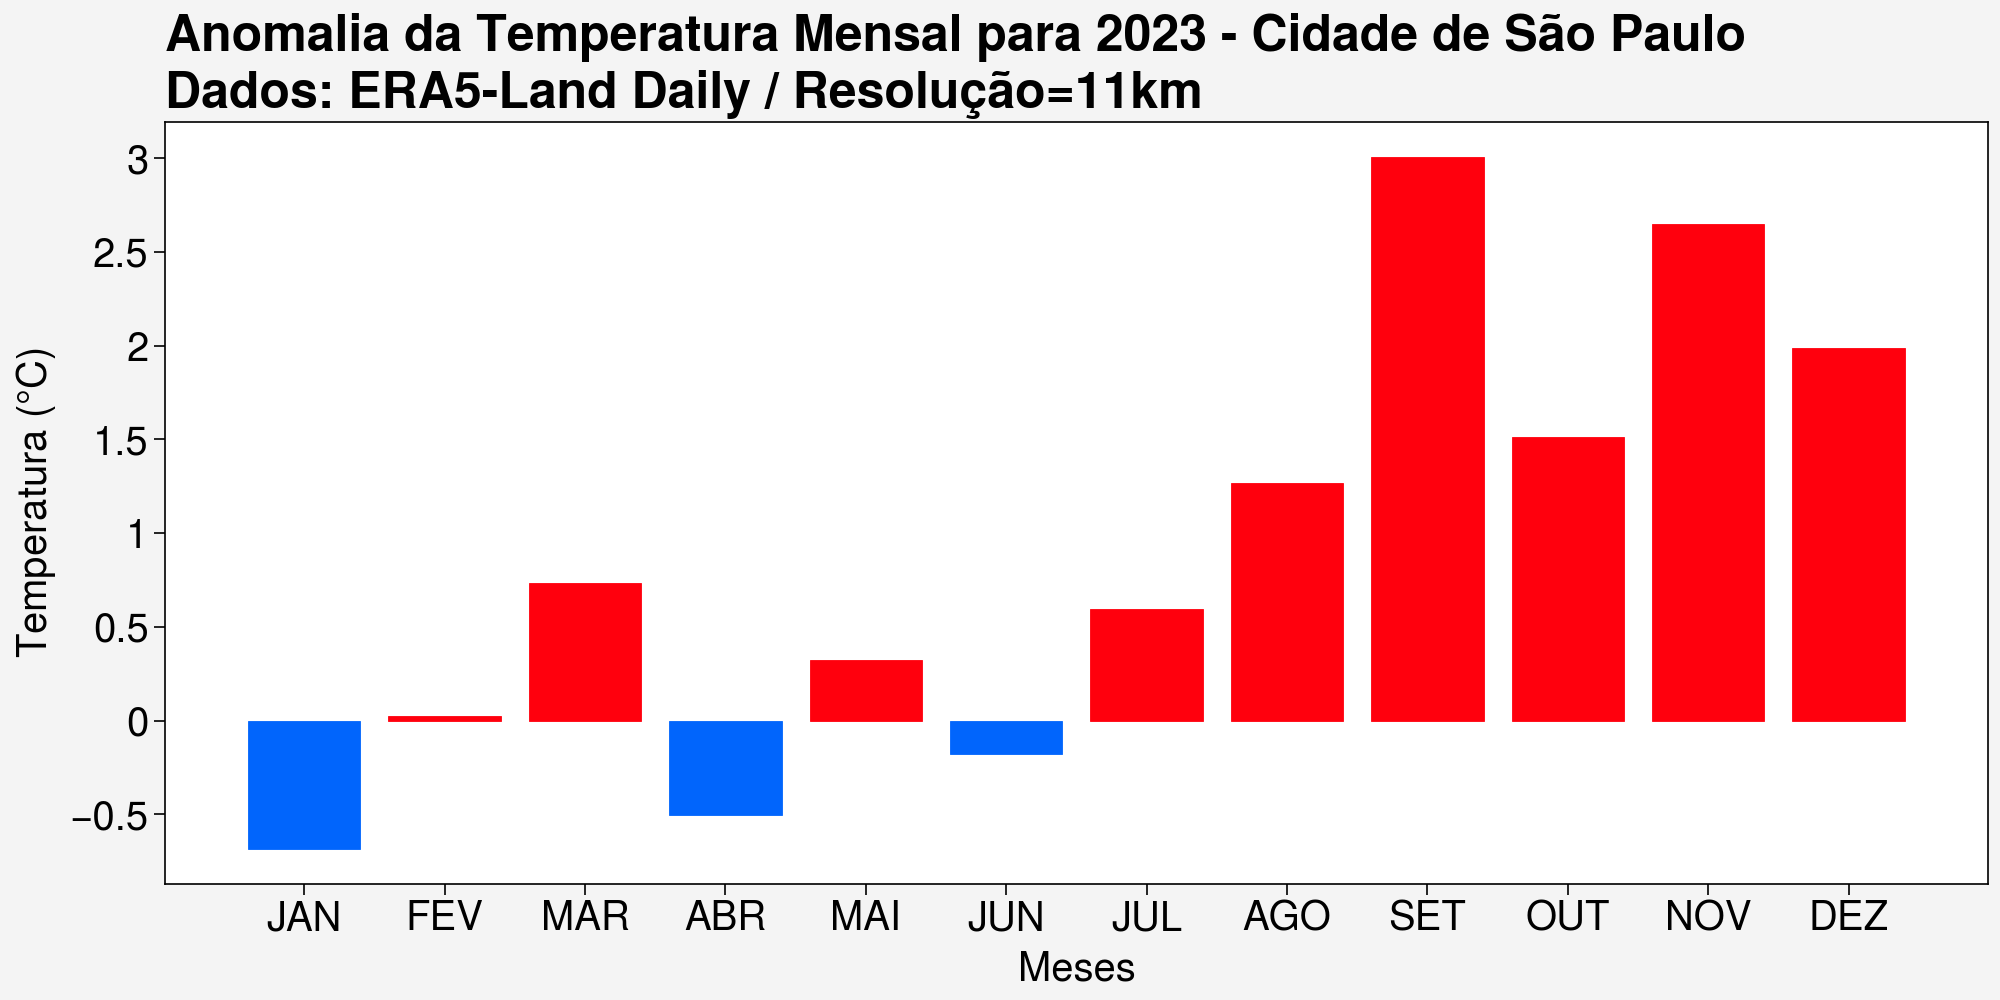

In [33]:
%%time
#========================================================================================================================#
#                                              LEITURA DO DADO
#========================================================================================================================#
# leitura do arquivo
df = pd.read_csv(f'{dir}output/ERA5_t2m_diaria_1950_2024.csv')

# transformando para DateTime
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)

# transformando a coluna de datas('date') no índice do DataFrame
df.index = df['date']

# remove colunas
df.drop(['Unnamed: 0', 'date'], inplace=True, axis=1)

#========================================================================================================================#
#                                          ACUMULA PARA MENSAL
#========================================================================================================================#
# valores por mês
df_mensal = df.groupby(pd.Grouper(freq='1M')).mean()

# seleciona os meses do ano de 2023
df_mensal_2023 = df_mensal['2023']

# climatologia
climatologia = df_mensal.groupby(df_mensal.index.month).mean()

# anomalia
anomalia_2023 = df_mensal_2023['temperature_2m'].values - climatologia['temperature_2m'].values

#========================================================================================================================#
#                                                PLOTA FIGURA
#========================================================================================================================#
# moldura da figura
fig, ax = pplt.subplots(figsize=(10,5), tight=True)

# plota gráfico de barras
# o argumento negpos=True serve para colorir áreas negativas e positivas
ax.bar(pplt.arange(1, 12, 1),
       anomalia_2023,
       negpos=True, negcolor='bright blue', poscolor='bright red', label='Anomalia')

# formato dos eixos
ax.format(title=f'Anomalia da Temperatura Mensal para 2023 - Cidade de São Paulo \nDados: ERA5-Land Daily / Resolução=11km',
          titleloc='l',
          titleweight='bold',
          titlecolor='black',
          ylabel='Temperatura ($\degree$C)',
          small='20px',
          large='25px',
          xlabel='Meses', xticks=1,
          xticklabels=['', 'JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ'],
          xrotation=0, xtickminor=False, ytickminor=False, grid=False)

# salva figura
fig.save(f'{dir}output/Fig_4_ERA5_anomalia_t2m_serie_temporal_mensal.jpg', dpi=300)

## Plota figura - Distribuição de temperatura por `ano e mês`

Uma mesma série temporal pode ser representada de diversas maneiras. Até aqui já vimos algumas, como gráficos de linhas e de barras, mas as opções são enormes e as suas escolhas devem se pautar de acordo com o **público**, **nível do trabalho** e, claro, a sua própria *expertise*.

Além das linhas e barras, uma maneira visualmente interessante de representar séries temporais é pelos chamados *heatmaps* (um exemplo claro hoje em dia são as *Warming Stripes* do Aquecimento Global).

Então vamos criar aqui um `heatmap` mensal de NDVI entre 2014 a 2021 usando a função `.heatmap()` do pacote `Seaborn`, mas antes, vamos precisar **reorganizar** o formato da nossa série: de um vetor coluna para uma matriz onde as linhas são os anos e colunas os meses.

In [ ]:
# valores por mês
df_mensal = df.groupby(pd.Grouper(freq='1M')).mean()

# seleciona os meses do ano de 2023
df_mensal_2023 = df_mensal['2023']

# climatologia
climatologia = df_mensal.groupby(df_mensal.index.month).mean()

# anomalia
anomalia_2023 = df_mensal_2023['temperature_2m'].values - climatologia['temperature_2m'].values

for ano in np.arange(2019,2024):

    # extrai aquele ano
    df_mensal_ano = df_mensal[str(ano)]

    # anomalia
    anomalia_ano = df_mensal_ano['temperature_2m'].values - climatologia['temperature_2m']

anomalia_ano


date
1    -0.685092
2     0.026968
3     0.736257
4    -0.502317
5     0.324069
6    -0.176193
7     0.593886
8     1.266685
9     3.008277
10    1.514758
11    2.648746
12    1.989707
Name: temperature_2m, dtype: float64

In [ ]:
anomalia_ano

array([-0.68509233,  0.02696832,  0.73625658, -0.50231702,  0.32406928,
       -0.17619296,  0.59388599,  1.26668485,  3.00827665,  1.51475826,
        2.64874629,  1.9897066 ])

In [ ]:
# matriz com formato de anos x meses entre 2014 a 2020 (anos completos)
ndvi = np.reshape(indices_mensais_interp['NDVI']['2014-01-01':'2021-12-31'].values, (8, 12), order='C')

In [ ]:
ndvi.shape

In [ ]:
# deixando o proplot de lado e voltando para o bom e velho matplotlib
fig, ax = plt.subplots(figsize=(10, 5))

# criando heatmap com seaborn
sns.heatmap(ndvi, vmin=0, vmax=1, cmap='RdYlGn',
            xticklabels=['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN',
                        'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ'],
            yticklabels=pplt.arange(2014, 2020, 1),
            linewidth=0.5, linecolor='grey',
            cbar_kws={'label': 'NDVI'}, annot=True,)

plt.tight_layout()
plt.show()

In [ ]:
%%time
#========================================================================================================================#
#                                              LEITURA DO DADO
#========================================================================================================================#
# leitura do arquivo
df = pd.read_csv(f'{dir}output/ERA5_t2m_diaria_1950_2024.csv')

# transformando para DateTime
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)

# transformando a coluna de datas('date') no índice do DataFrame
df.index = df['date']

# remove colunas
df.drop(['Unnamed: 0', 'date'], inplace=True, axis=1)

#========================================================================================================================#
#                                          ACUMULA PARA MENSAL
#========================================================================================================================#
# valores por mês
df_mensal = df.groupby(pd.Grouper(freq='1M')).mean()

# seleciona os meses do ano de 2023
df_mensal_2023 = df_mensal['2023']

# climatologia
climatologia = df_mensal.groupby(df_mensal.index.month).mean()

# anomalia
anomalia_2023 = df_mensal_2023['temperature_2m'].values - climatologia['temperature_2m'].values




CPU times: user 89.6 ms, sys: 1.06 ms, total: 90.7 ms
Wall time: 123 ms


In [ ]:
anomalia_2023

array([-0.68509233,  0.02696832,  0.73625658, -0.50231702,  0.32406928,
       -0.17619296,  0.59388599,  1.26668485,  3.00827665,  1.51475826,
        2.64874629,  1.9897066 ])

# **PARTE 3)**:  Mapa de anomalia
- Dados: https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY_AGGR

##Plotando mapa de `anomalia de temperatura` no GEE

In [46]:
# selecionar apenas as imagens entre Dezembro, Janeiro e Fevereiro
#indices_verao = landsat8.filter(ee.Filter.calendarRange(12, 2, 'month'))

#.filterDate('2020-01-01', '2024-12-01') \

#landsat8_jul21 = landsat8.filterDate('2021-07-01', '2021-07-31')

# filtragem somente para os julhos de todos os anos (desde 2013)
#landsat8_media_julho = landsat8.filter(ee.Filter.calendarRange(7, 7, 'month'))

# cálculo do desvio em relação a média histórica
#desvio = landsat8_jul21.mean().subtract(landsat8_media_julho.mean())

In [47]:
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
estado_sp = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
municipio_sp = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo'))

#========================================================================================================================#
#                                            CARREGA OS DADOS
#========================================================================================================================#
# função que transforma de Kelvin para Celsius
def kelvin_to_celsius(image):
    return image.subtract(273.15)\
                .copyProperties(image, ['system:time_start'])\
                .set('date', image.date().format('YYYY-MM-dd'))

# carregando os dados
t2m = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR') \
        .select('temperature_2m') \
        .filter(ee.Filter.calendarRange(1990,2025,'year')) \
        .map(kelvin_to_celsius)

#========================================================================================================================#
#                                            CALCULA ANOMALIA
#========================================================================================================================#
# seleciona o dados de dezembro de todos os anos
t2m_dez = t2m.filter(ee.Filter.calendarRange(12,12,'month'))

# seleciona dezembro de 2023
dez_2023 = t2m.filterDate('2023-12-01','2024-01-01')

# calcula anomalia
anomalia = dez_2023.mean().subtract(t2m_dez.mean())

#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# parâmetros de visualização
vis = {'min': -2.0,
       'max': 2.0,
       'palette': ['000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff', '00ff80',
                   '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00', 'ffb000', 'ffa400',
                   'ff4f00', 'ff2500', 'ff0a00', 'ff00ff']}

# cria a moldura do mapa
Map = geemap.Map()

# centraliza o mapa
Map.centerObject(brasil)

# plota mapa
Map.addLayer(anomalia.clip(brasil),
             vis,
             'Anomalia de Temperatura')

# contorno da região
style1 = {'color': 'black', 'fillColor': '00000000'}
Map.addLayer(brasil.style(**style1), {}, 'brasil')

# barra de cores
colors = vis["palette"]
vmin = vis["min"]
vmax = vis["max"]
Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name='Anomalia de Temperatura')

# exibe na tela
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

##Plotando mapa de `anomalia de temperatura` no Proplot

Produz arquivo netcdf

In [48]:
%%time
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
estado_sp = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
municipio_sp = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo'))

#========================================================================================================================#
#                                            CARREGA OS DADOS
#========================================================================================================================#
# função que transforma de Kelvin para Celsius
def kelvin_to_celsius(image):
    return image.subtract(273.15)\
                .copyProperties(image, ['system:time_start'])\
                .set('date', image.date().format('YYYY-MM-dd'))

# carregando os dados
t2m = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR') \
        .select('temperature_2m') \
        .filter(ee.Filter.calendarRange(1990,2025,'year')) \
        .map(kelvin_to_celsius)

#========================================================================================================================#
#                                            DEFINE O ANO E MES
#========================================================================================================================#
# importa biblioteca
from datetime import datetime

# define o ano e mês da anomalia
ano, mes = '2023', '12'
date = f'{ano}-{mes}' #'2022-12'

# transforma a data para datetime
test_date = datetime(int(ano), int(mes), 1)

# cria um dicionario com o numero do mes como chave e o nome do mes como
mes_dic =  {1: "Janeiro",
            2: "Fevereiro",
            3: "Março",
            4: "Abril",
            5: "Maio",
            6: "Junho",
            7: "Julho",
            8: "Augosto",
            9: "Setembro",
            10: "Outubro",
            11: "Novembro",
            12: "Dezembro"}

# usa o dicionario para obter o nome do mes a partir do numero do mês
nome_mes = mes_dic[test_date.month]

#========================================================================================================================#
#                                            CALCULA ANOMALIA
#========================================================================================================================#
# range de datas
range = ee.Date(date).getRange('month')

# seleciona o dados de dezembro de todos os anos
t2m_dez = t2m.filter(ee.Filter.calendarRange(int(date[5:7]),int(date[5:7]),'month'))

# seleciona dezembro de 2023
dez_2023 = t2m.filter(ee.Filter.date(range))

# calcula anomalia
anomalia = dez_2023.mean().subtract(t2m_dez.mean()).set('system:time_start', f'{ano}-{mes}-01')

#========================================================================================================================#
#                                           SALVA ARQUIVO NETCDF
#========================================================================================================================#
# convertendo para xarray.Dataset: anomalia
ds_anomalia = anomalia.clip(brasil).wx.to_xarray(region=brasil.geometry(), scale=11_000)

# convertendo para xarray.Dataset: média daquele mês
ds_media = dez_2023.mean().set('system:time_start', f'{ano}-{mes}-01').clip(brasil).wx.to_xarray(region=brasil.geometry(), scale=11_000)

# salva arquivo netcdf
ds_anomalia.to_netcdf(f'{dir}output/ERA5_anomalia_t2m_{date}.nc')
ds_media.to_netcdf(f'{dir}output/ERA5_media_t2m_{date}.nc')

Downloading:   0%|          | 0.00/492k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/284k [00:00<?, ?iB/s]

CPU times: user 733 ms, sys: 58.1 ms, total: 791 ms
Wall time: 54.2 s


In [49]:
# mostra a imageCollection daquele mês
dez_2023

In [50]:
# mostra o dataset de temperatura
ds_media

<xarray.Dataset>
Dimensions:         (time: 1, x: 458, y: 396)
Coordinates:
  * time            (time) datetime64[ns] 2023-12-01
  * x               (x) float64 -73.96 -73.86 -73.77 ... -29.0 -28.9 -28.8
  * y               (y) float64 5.287 5.188 5.089 4.99 ... -33.55 -33.65 -33.75
    spatial_ref     int64 0
Data variables:
    temperature_2m  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

In [51]:
# mostra dados de anomalia
ds_anomalia

<xarray.Dataset>
Dimensions:         (time: 1, x: 458, y: 396)
Coordinates:
  * time            (time) datetime64[ns] 2023-12-01
  * x               (x) float64 -73.96 -73.86 -73.77 ... -29.0 -28.9 -28.8
  * y               (y) float64 5.287 5.188 5.089 4.99 ... -33.55 -33.65 -33.75
    spatial_ref     int64 0
Data variables:
    temperature_2m  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

Plota figura de anomalia

CPU times: user 7.01 s, sys: 614 ms, total: 7.62 s
Wall time: 8.61 s


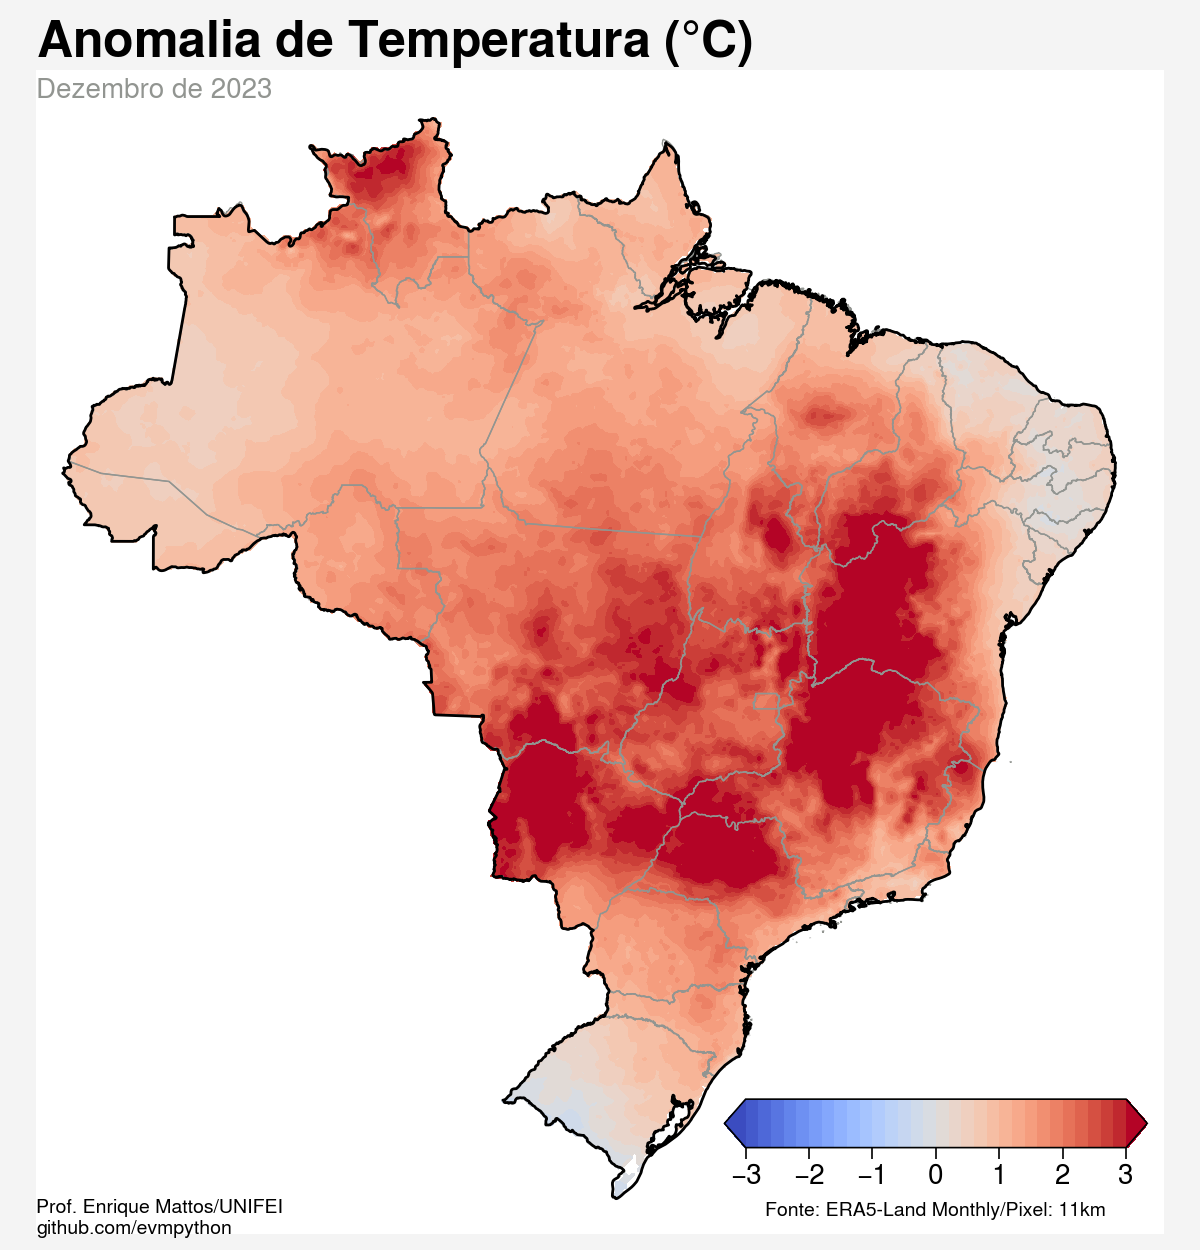

In [52]:
%%time
#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura da figura
fig, ax = pplt.subplots(axwidth=6, tight=True, proj='pcarree')

# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          title=f'Anomalia de Temperatura ($\degree$C)',
          titleloc='l',
          titleweight='bold',
          titlecolor='black',
          small='20px', large='25px',
          linewidth=0, grid=False)

# plota subtítulo
ax.text(lonmin, latmax-1.0, f'{nome_mes} de {ano}', color='grey', fontsize=10)

# plota mapa
map1 = ax.contourf(ds_anomalia['x'],
                   ds_anomalia['y'],
                   ds_anomalia['temperature_2m'][0,:,:],
                   extend='both',
                   cmap='coolwarm',
                   vmin=-5, vmax=5,
                   levels=pplt.arange(-3, 3, 0.2),
                   colorbar='best',
                   colorbar_kw={'label': 'Fonte: ERA5-Land Monthly/Pixel: 11km',
                                'length': 18,
                                'frameon': False,
                                'ticklabelsize': 10,
                                'labelsize': 7,
                                'width': 2,
                                'ticks': 1})

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax)

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax)

# informação na figura
ax.annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

# salva figura
fig.save(f'{dir}output/Fig_6_ERA5_anomalia_t2m_{date}.png', dpi=300)

##Plotando mapa de `anomalia e média de temperatura` no Proplot

CPU times: user 16.1 s, sys: 1.25 s, total: 17.4 s
Wall time: 19.8 s


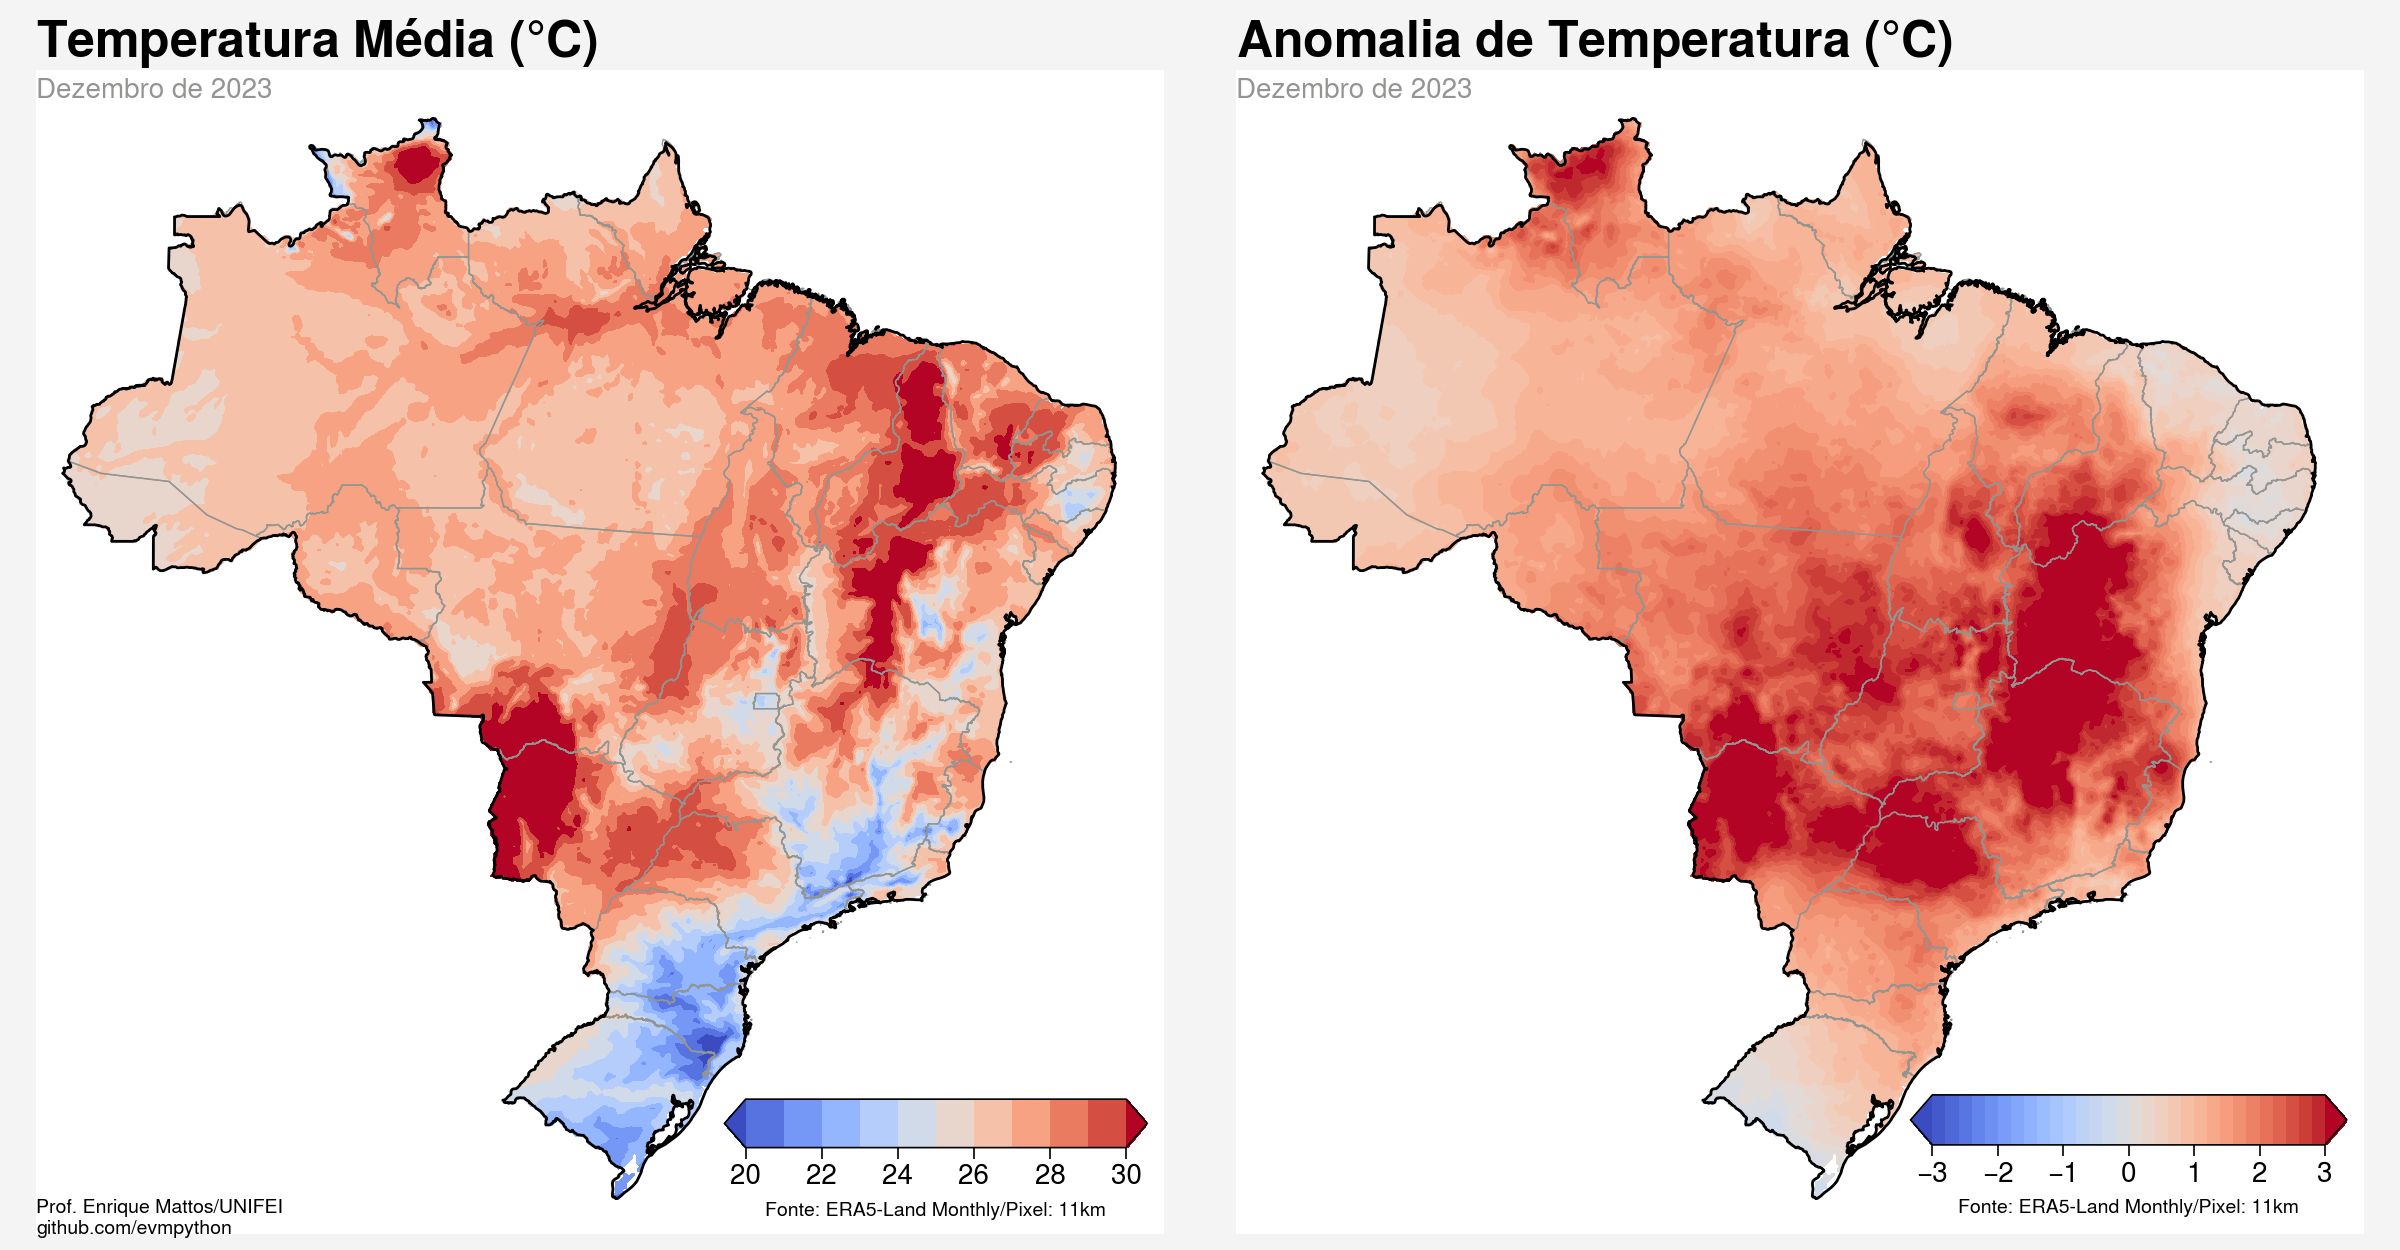

In [54]:
%%time
#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura da figura
fig, ax = pplt.subplots(axwidth=6, ncols=2, nrows=1, tight=True, proj='pcarree')

# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False)

# plota subtítulo
ax.text(lonmin, latmax-1.0, f'{nome_mes} de {ano}', color='grey', fontsize=10)

#--------------------------------------------------------------#
#                            FIG-1
#--------------------------------------------------------------#
# plota mapa
map1 = ax[0].contourf(ds_media['x'],
                      ds_media['y'],
                      ds_media['temperature_2m'][0,:,:],
                      cmap='coolwarm',
                      vmin=20, vmax=30,
                      levels=pplt.arange(20, 30, 1),
                      extend='both',
                      colorbar='best',
                      colorbar_kw={'label': 'Fonte: ERA5-Land Monthly/Pixel: 11km',
                                   'length': 18,
                                   'frameon': False,
                                   'ticklabelsize': 10,
                                   'labelsize': 7,
                                   'width': 2,
                                   'ticks': 2})

# título da figura
ax[0].format(title=f'Temperatura Média ($\degree$C)',
          titleloc='l',
          titleweight='bold',
          titlecolor='black')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[0])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])

# informação na figura
ax[0].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

#--------------------------------------------------------------#
#                            FIG-2
#--------------------------------------------------------------#
ax[1].contourf(ds_anomalia['x'],
               ds_anomalia['y'],
               ds_anomalia['temperature_2m'][0,:,:],
               cmap='coolwarm',
               vmin=-2, vmax=2,
               levels=pplt.arange(-3, 3, 0.2),
               extend='both',
               colorbar='best',
               colorbar_kw={'label': 'Fonte: ERA5-Land Monthly/Pixel: 11km',
                            'length': 18,
                            'frameon': False,
                            'ticklabelsize': 10,
                            'labelsize': 7,
                            'width': 2,
                            'ticks': 1})

# título da figura
ax[1].format(title=f'Anomalia de Temperatura ($\degree$C)',
          titleloc='l',
          titleweight='bold',
          titlecolor='black')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[1])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

# salva figura
fig.save(f'{dir}output/Fig_7_ERA5_temp_anomalia_t2m_{date}.png', dpi=300)

##Plotando mapa de `precipitação` no GEE
- Dados: https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY_AGGR

In [55]:
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
estado_sp = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
municipio_sp = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo'))

#========================================================================================================================#
#                                            CARREGA OS DADOS
#========================================================================================================================#
# função que transforma de metros para milímetros
def metros_to_milimetros(image):
    return image.multiply(1000.0)\
                .copyProperties(image, ['system:time_start'])\
                .set('date', image.date().format('YYYY-MM-dd'))

# carrega os dados
precip = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR') \
           .select('total_precipitation_sum') \
           .filterDate('2022-05-01', '2022-06-01') \
           .map(metros_to_milimetros)

#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# parâmetros de visualização
vis = {'min': 50,
       'max': 400,
       'palette': ['000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff', '00ff80',
                   '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00', 'ffb000', 'ffa400',
                   'ff4f00', 'ff2500', 'ff0a00', 'ff00ff']}

# cria a moldura do mapa
Map = geemap.Map()

# centraliza o mapa
Map.centerObject(brasil)

# plota mapa
Map.addLayer(precip.sum().clip(brasil), vis, 'Precipitação Maio/2022')

# contorno da região
style1 = {'color': 'black', 'fillColor': '00000000'}
Map.addLayer(brasil.style(**style1), {}, 'brasil')

# barra de cores
colors = vis["palette"]
vmin = vis["min"]
vmax = vis["max"]
Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name='Precipitação (mm/ano)')

# exibe na tela
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [56]:
precip

##Plotando mapa de `anomalia e acumulado de precipitação` no Proplot
- https://proplot.readthedocs.io/en/latest/colormaps.html

###Produz arquivo netcdf

In [61]:
%%time
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
estado_sp = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
municipio_sp = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo'))

#========================================================================================================================#
#                                            CARREGA OS DADOS
#========================================================================================================================#
# função que transforma de metros para milímetros
def metros_to_milimetros(image):
    return image.multiply(1000.0)\
                .copyProperties(image, ['system:time_start'])\
                .set('date', image.date().format('YYYY-MM-dd'))

# carrega os dados
precip = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR') \
           .select('total_precipitation_sum') \
           .filter(ee.Filter.calendarRange(1990,2025,'year')) \
           .map(metros_to_milimetros)

#========================================================================================================================#
#                                            DEFINE O ANO E MES
#========================================================================================================================#
# importa biblioteca
from datetime import datetime

# define o ano e mês da anomalia
ano, mes = '2023', '12'
date = f'{ano}-{mes}' #'2022-12'

# transforma a data para datetime
test_date = datetime(int(ano), int(mes), 1)

# cria um dicionario com o numero do mes como chave e o nome do mes como
mes_dic =  {1: "Janeiro",
            2: "Fevereiro",
            3: "Março",
            4: "Abril",
            5: "Maio",
            6: "Junho",
            7: "Julho",
            8: "Augosto",
            9: "Setembro",
            10: "Outubro",
            11: "Novembro",
            12: "Dezembro"}

# usa o dicionario para obter o nome do mes a partir do numero do mês
nome_mes = mes_dic[test_date.month]

#========================================================================================================================#
#                                            CALCULA ANOMALIA
#========================================================================================================================#
# range de datas
range = ee.Date(date).getRange('month')

# seleciona o dados de todos os DEZEMBROS
precip_dez = precip.filter(ee.Filter.calendarRange(int(date[5:7]),int(date[5:7]),'month'))

# seleciona DEZEMBRO de 2023
precip_dez_2023 = precip.filter(ee.Filter.date(range))

# calcula anomalia
anomalia_precip = precip_dez_2023.sum().subtract(precip_dez.mean()).set('system:time_start', f'{ano}-{mes}-01')

#========================================================================================================================#
#                                           SALVA ARQUIVO NETCDF
#========================================================================================================================#
# convertendo para xarray.Dataset: anomalia
ds_anomalia = anomalia_precip.clip(brasil).wx.to_xarray(region=brasil.geometry(), scale=11_000)

# convertendo para xarray.Dataset: média daquele mês
ds_media = precip_dez_2023.sum().set('system:time_start', f'{ano}-{mes}-01').clip(brasil).wx.to_xarray(region=brasil.geometry(), scale=11_000)

# salva arquivo netcdf
ds_anomalia.to_netcdf(f'{dir}output/ERA5_anomalia_precipitacao_{date}.nc')
ds_media.to_netcdf(f'{dir}output/ERA5_media_precipitacao_{date}.nc')

Downloading:   0%|          | 0.00/468k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/366k [00:00<?, ?iB/s]

CPU times: user 948 ms, sys: 92.4 ms, total: 1.04 s
Wall time: 1min 27s


In [62]:
ds_media

<xarray.Dataset>
Dimensions:                  (time: 1, x: 458, y: 396)
Coordinates:
  * time                     (time) datetime64[ns] 2023-12-01
  * x                        (x) float64 -73.96 -73.86 -73.77 ... -28.9 -28.8
  * y                        (y) float64 5.287 5.188 5.089 ... -33.65 -33.75
    spatial_ref              int64 0
Data variables:
    total_precipitation_sum  (time, y, x) float64 nan nan nan ... nan nan nan
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

In [63]:
ds_anomalia

<xarray.Dataset>
Dimensions:                  (time: 1, x: 458, y: 396)
Coordinates:
  * time                     (time) datetime64[ns] 2023-12-01
  * x                        (x) float64 -73.96 -73.86 -73.77 ... -28.9 -28.8
  * y                        (y) float64 5.287 5.188 5.089 ... -33.65 -33.75
    spatial_ref              int64 0
Data variables:
    total_precipitation_sum  (time, y, x) float64 nan nan nan ... nan nan nan
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

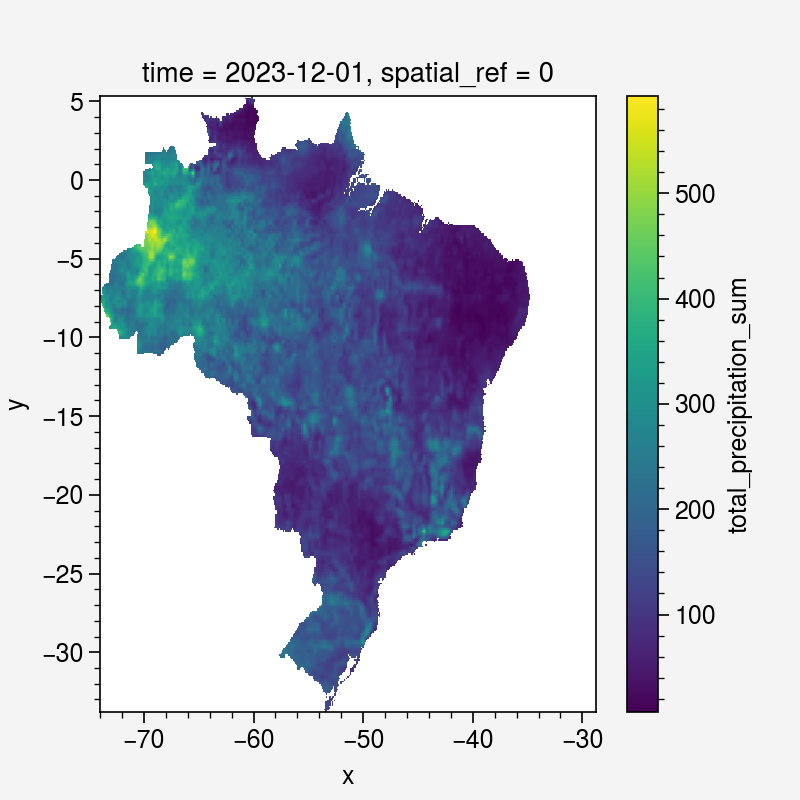

In [66]:
ds_media['total_precipitation_sum'].plot()

###Plota figura

CPU times: user 15 s, sys: 1.6 s, total: 16.6 s
Wall time: 19.4 s


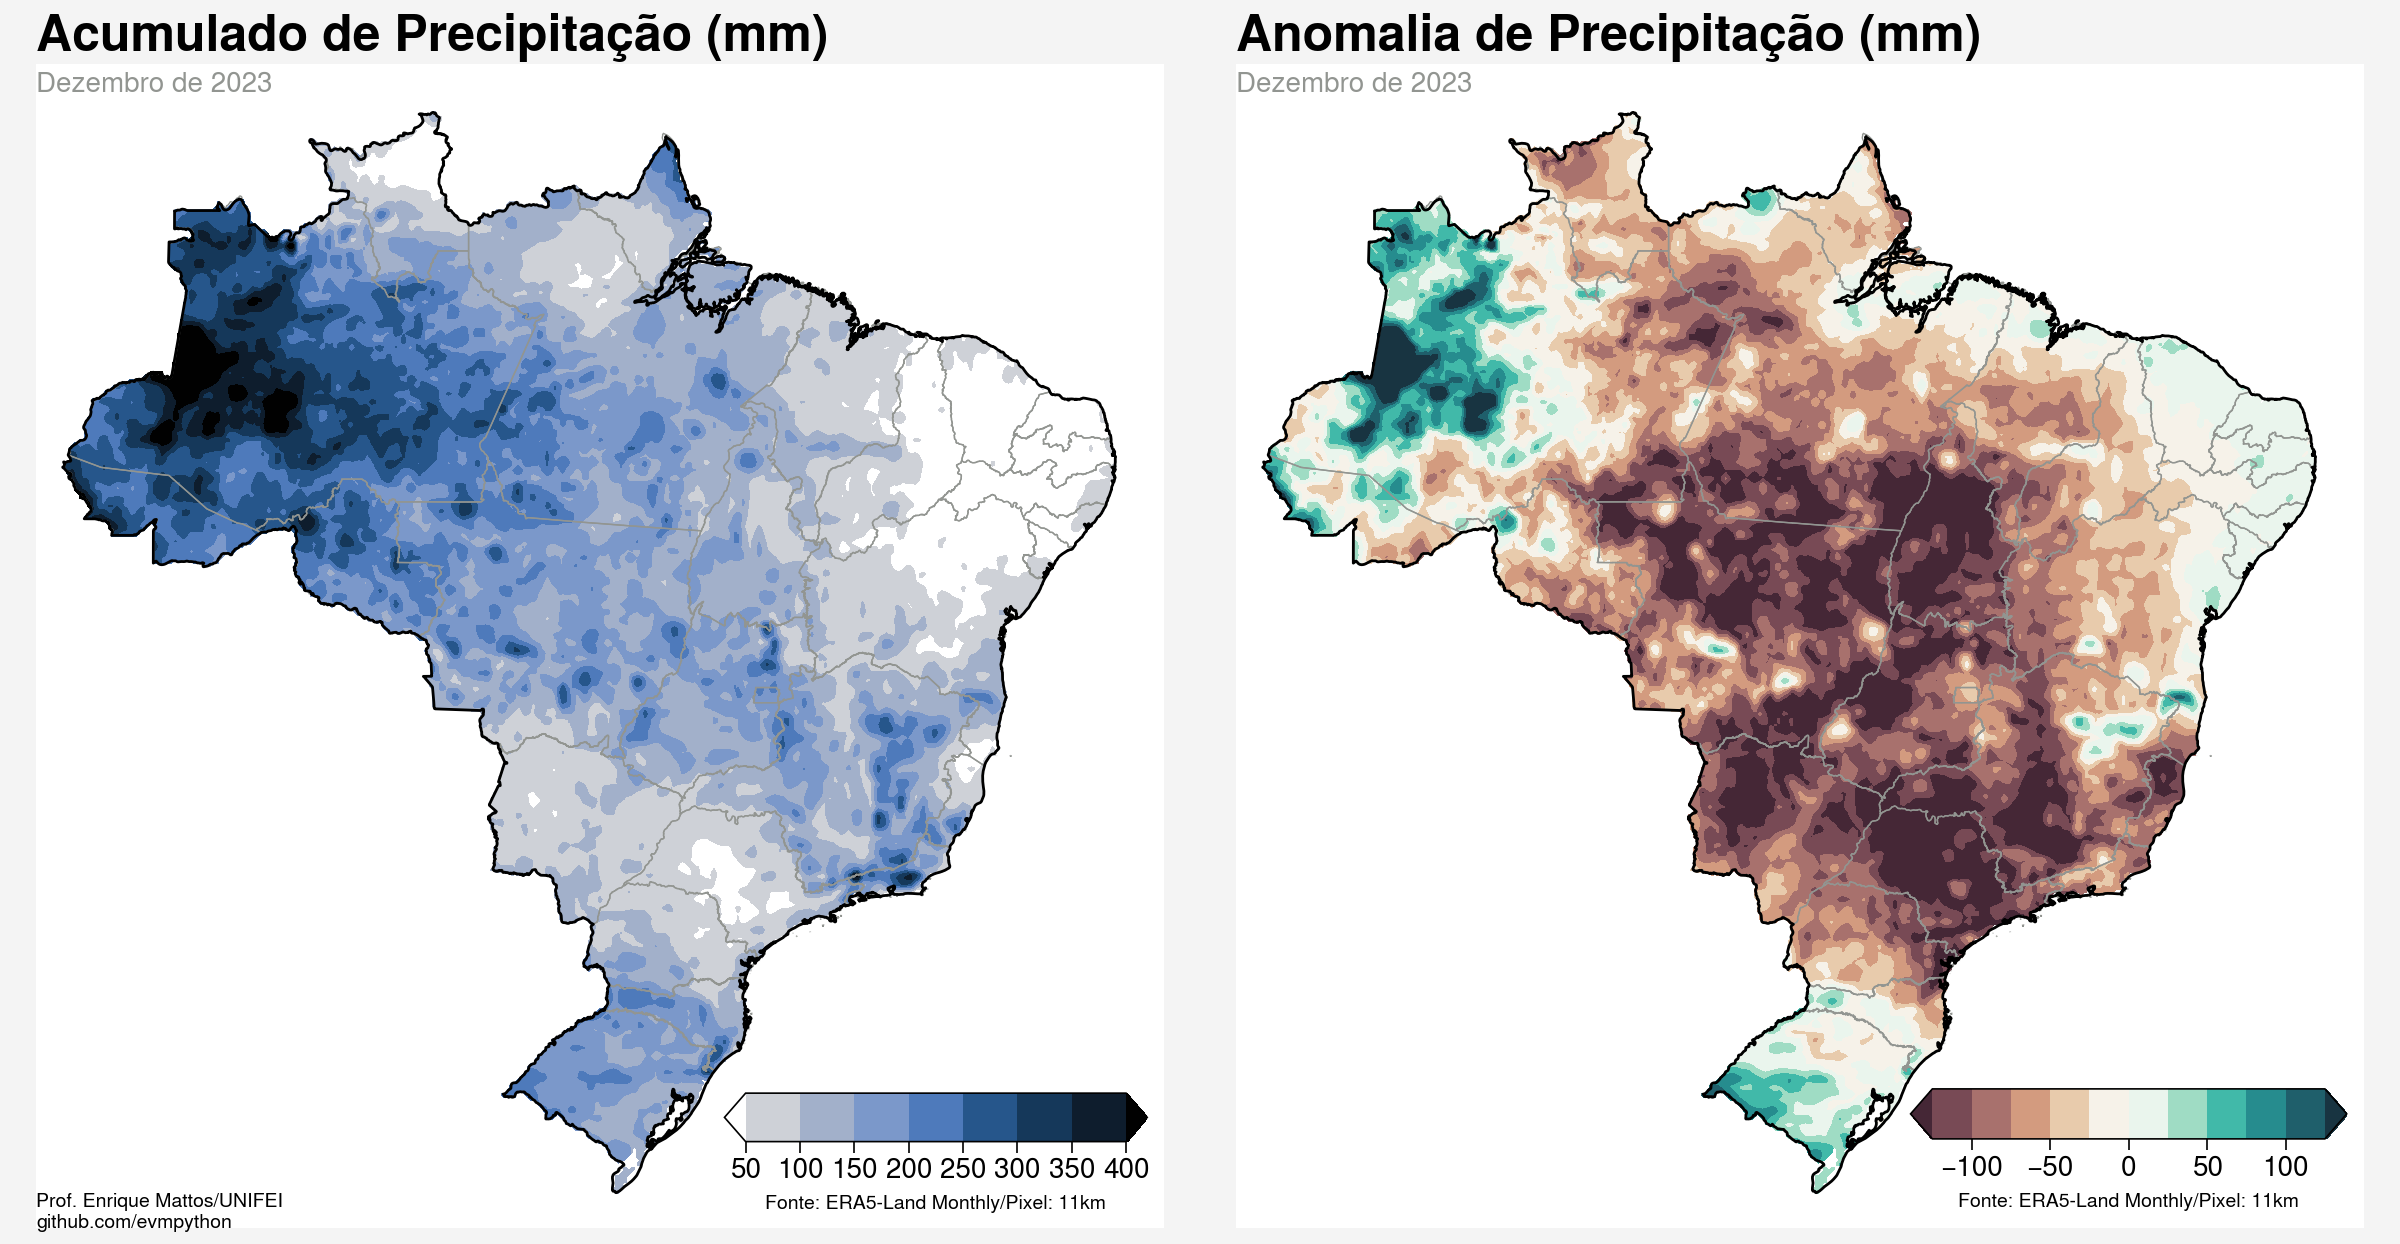

In [64]:
%%time
#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura da figura
fig, ax = pplt.subplots(axwidth=6, ncols=2, nrows=1, tight=True, proj='pcarree')

# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False)

# plota subtítulo
ax.text(lonmin, latmax-1.0, f'{nome_mes} de {ano}', color='grey', fontsize=10)

#--------------------------------------------------------------#
#                            FIG-1
#--------------------------------------------------------------#
# plota mapa
map1 = ax[0].contourf(ds_media['x'],
                      ds_media['y'],
                      ds_media['total_precipitation_sum'][0,:,:],
                      cmap='oslo_r',
                      vmin=50, vmax=400,
                      levels=pplt.arange(50, 400, 50),
                      extend='both',
                      colorbar='best',
                      colorbar_kw={'label': 'Fonte: ERA5-Land Monthly/Pixel: 11km',
                                   'length': 18,
                                   'frameon': False,
                                   'ticklabelsize': 10,
                                   'labelsize': 7,
                                   'width': 2,
                                   'ticks': 50})

# título da figura
ax[0].format(title=f'Acumulado de Precipitação (mm)',
          titleloc='l',
          titleweight='bold',
          titlecolor='black')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[0])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])

# informação na figura
ax[0].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

#--------------------------------------------------------------#
#                            FIG-2
#--------------------------------------------------------------#
ax[1].contourf(ds_anomalia['x'],
               ds_anomalia['y'],
               ds_anomalia['total_precipitation_sum'][0,:,:],
               cmap='DryWet',
               vmin=-125, vmax=125,
               levels=pplt.arange(-125, 125, 25),
               extend='both',
               colorbar='best',
               colorbar_kw={'label': 'Fonte: ERA5-Land Monthly/Pixel: 11km',
                            'length': 18,
                            'frameon': False,
                            'ticklabelsize': 10,
                            'labelsize': 7,
                            'width': 2,
                            'ticks': 50})

# título da figura
ax[1].format(title=f'Anomalia de Precipitação (mm)',
          titleloc='l',
          titleweight='bold',
          titlecolor='black')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[1])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

# salva figura
fig.save(f'{dir}output/Fig_8_ERA5_acum_anomalia_precipitacao_{date}.png', dpi=300)